# Implémentation d'un VAE


Dans ce notebook, on va implémenter un VAE pour générer des images à partir du dataset MNIST.
On commence par un autoencodeur classique pour montrer qu'une telle architecture ne permet pas de générer de nouveaux éléments.


In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset


On commence par charger le dataset MNIST :


In [2]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

print("taille du dataset d'entrainement : ",len(dataset))
print("taille d'une image : ",dataset[0][0].numpy().shape) 

train_dataset, validation_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

taille du dataset d'entrainement :  60000
taille d'une image :  (1, 28, 28)


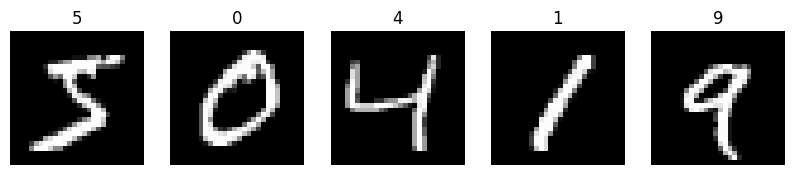

In [21]:
# Visualisons quelques images
plt.figure(figsize=(10, 10))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(dataset[i][0].squeeze(), cmap='gray')
  plt.axis('off')
  plt.title(dataset[i][1])

## Autoencodeur sur MNIST


On construit l'architecture de notre autoencodeur :


In [22]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> [16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # -> [8, 7, 7]
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, stride=2, padding=1)   # -> [8, 4, 4]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
dummy_input = torch.randn(1, 1, 28, 28) 
model = AE()
output = model(dummy_input)
print(output.shape)

torch.Size([1, 1, 28, 28])


On définit nos hyperparamètres d'entraînement :


In [23]:
epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

On passe à l'entraînement du modèle :


In [24]:
for epoch in range(epochs): 
    for img,_ in train_loader:
        optimizer.zero_grad()
        recon = model(img)
        loss = criterion(recon, img)
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, epochs, loss.item()))

epoch [1/10], loss:0.0330
epoch [2/10], loss:0.0220
epoch [3/10], loss:0.0199
epoch [4/10], loss:0.0186
epoch [5/10], loss:0.0171
epoch [6/10], loss:0.0172
epoch [7/10], loss:0.0175
epoch [8/10], loss:0.0168
epoch [9/10], loss:0.0159
epoch [10/10], loss:0.0148


On vérifie le comportement du modèle sur les données de test :


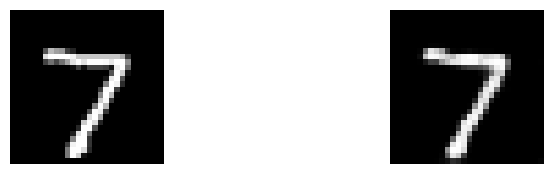

In [25]:
for data in test_loader:
    img, _ = data
    recon = model(img)
    break
plt.figure(figsize=(9, 2))
plt.gray()
plt.subplot(1, 2, 1)
plt.imshow(img[0].detach().numpy().squeeze())
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(recon[0].detach().numpy().squeeze())
plt.axis('off')
plt.show()

On visualise maintenant l'espace latent et la répartition des 10 classes dans cet espace.


In [26]:
# On commence par extraire les représentations latentes des données de test
latents = []
labels = []

with torch.no_grad():
    for data, target in test_loader:
        latent = model.encoder(data)
        latents.append(latent)
        labels.append(target)

latents = torch.cat(latents)
labels = torch.cat(labels)

On utilise la méthode [T-SNE](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a) pour extraire des représentations en 2D et visualiser les données.


In [27]:
from sklearn.manifold import TSNE

latents_flat = latents.view(latents.size(0), -1)
tsne = TSNE(n_components=2, random_state=0)
latent_2d = tsne.fit_transform(latents_flat)

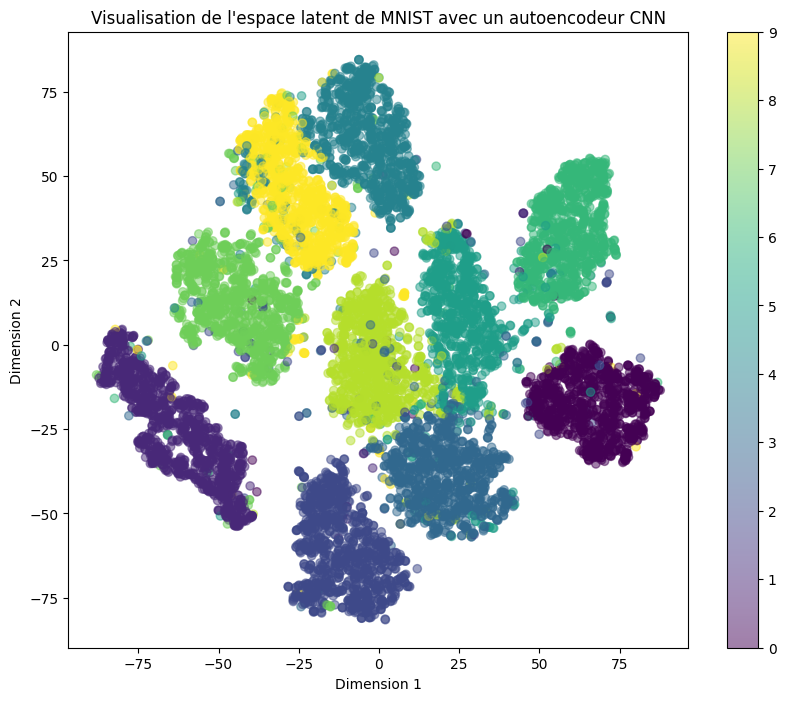

In [28]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('Visualisation de l\'espace latent de MNIST avec un autoencodeur CNN')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

Comme prévu, les classes sont bien séparées dans l'espace latent. Cependant, il y a beaucoup d'espaces vides, ce qui rend difficile le sampling d'un point aléatoire dans l'espace latent et l'espérance de générer une donnée réelle cohérente.


On regarde ce qu'on obtient en générant une image à partir d'un point aléatoire de l'espace latent.


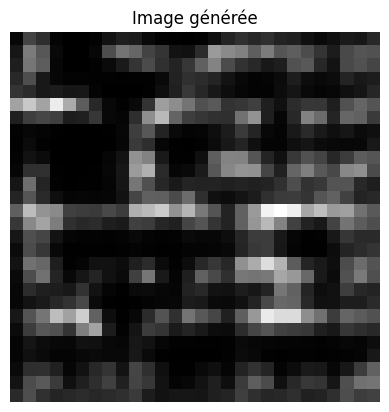

In [29]:
latent_dim = (8, 4, 4)
sampled_latent = torch.randn(latent_dim).unsqueeze(0)

# On générer l'image avec le décodeur
with torch.no_grad():
    generated_image = model.decoder(sampled_latent)

generated_image = generated_image.squeeze().numpy()  # Supprimer la dimension batch et convertir en numpy
generated_image = (generated_image + 1) / 2  # Dénormaliser l'image (car Tanh est utilisé)
plt.imshow(generated_image, cmap='gray')
plt.title("Image générée")
plt.axis('off')
plt.show()

Comme prévu, cela ne génère rien de cohérent.


## Variational Autoencoder


Maintenant, on reprend la même architecture (plus ou moins) mais avec un VAE pour voir si on peut générer des données.


In [70]:
class VAE(nn.Module):
    def __init__(self,latent_dim=8):
        super(VAE, self).__init__()
        # Encodeur
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> [16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # -> [8, 7, 7]
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, stride=2, padding=1)   # -> [8, 4, 4]
        )
        self.fc_mu = nn.Linear(8*4*4, latent_dim)
        self.fc_logvar = nn.Linear(8*4*4, latent_dim)
        
        # Décodeur
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 8*4*4),
            nn.ReLU()
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
    
    def encode(self, x):
        h = self.encoder_conv(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 8, 4, 4)
        return self.decoder_conv(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
    
dummy_input = torch.randn(1, 1, 28, 28)
model = VAE()
output,mu,logvar = model(dummy_input)  
print(output.shape, mu.shape, logvar.shape)

torch.Size([1, 1, 28, 28]) torch.Size([1, 8]) torch.Size([1, 8])


In [71]:
epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [72]:
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

for epoch in range(epochs): 
    for data,_ in train_loader:
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = loss_function(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss / len(train_loader.dataset)}')

Epoch 0, Loss: 0.1811039298772812
Epoch 1, Loss: 0.14575038850307465
Epoch 2, Loss: 0.14808794856071472
Epoch 3, Loss: 0.14365650713443756
Epoch 4, Loss: 0.14496898651123047
Epoch 5, Loss: 0.13169685006141663
Epoch 6, Loss: 0.1442883014678955
Epoch 7, Loss: 0.14070650935173035
Epoch 8, Loss: 0.12996357679367065
Epoch 9, Loss: 0.1352960765361786


In [73]:
latents = []
labels = []

with torch.no_grad():
    for data, target in test_loader:
        mu, logvar = model.encode(data)
        latents.append(mu)
        labels.append(target)

latents = torch.cat(latents)
labels = torch.cat(labels)

In [74]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
latent_2d = tsne.fit_transform(latents)

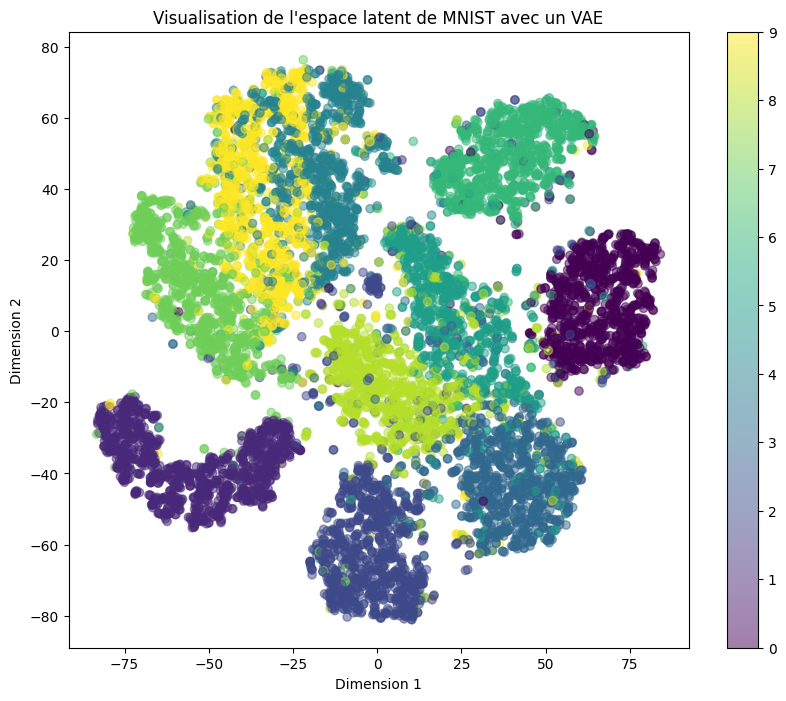

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('Visualisation de l\'espace latent de MNIST avec un VAE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

On constate que l'espace latent est encore très éparpillé. Cela s'explique par la différence entre le *loss* de reconstruction et la divergence de Kullback-Leibler. Dans notre entraînement, le *loss* de reconstruction était bien plus important que la divergence.

On peut maintenant générer des images. Comme l'espace latent n'a pas les caractéristiques de continuité et de complétude souhaitées, les éléments ne vont pas forcément ressembler à des chiffres réels.


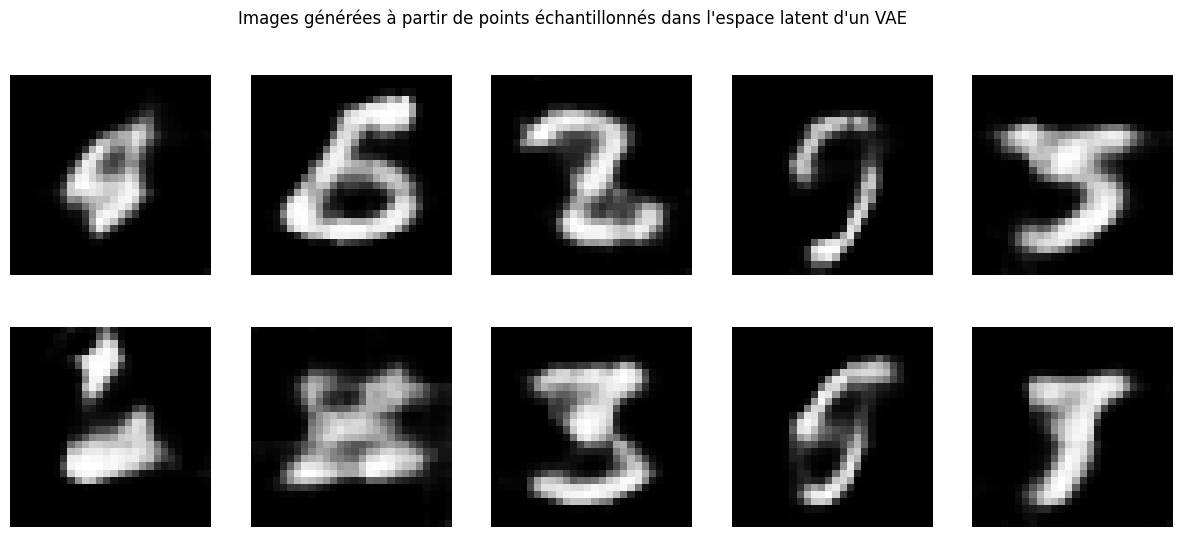

In [119]:
latent_dim = 8
num_images = 10  
images_per_row = 5  

sampled_latents = torch.randn(num_images, latent_dim)

with torch.no_grad():
    generated_images = model.decode(sampled_latents)

generated_images = generated_images.squeeze().numpy()  # Supprimer la dimension batch et convertir en numpy
generated_images = (generated_images + 1) / 2  # Dénormaliser les images (car Tanh est utilisé)

fig, axes = plt.subplots(2, images_per_row, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')

plt.suptitle("Images générées à partir de points échantillonnés dans l'espace latent d'un VAE")
plt.show()

Comme prévu, certaines images générées n'ont pas vraiment de sens.
Comme exercice, vous pouvez essayer d'améliorer la représentation latente pour générer des images cohérentes à chaque fois.
Attention, il y a toujours un compromis à faire entre qualité de reconstruction et espace latent.
